In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from IPython.display import display, HTML

In [0]:
#Librerias para usar Google Drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
#Leer_Datos
data_diab = pd.read_csv('/content/drive/My Drive/2020-1/Data TIA/diabetes.csv',sep='\t' ,header=0)
data_card = pd.read_csv('/content/drive/My Drive/2020-1/Data TIA/Enfermedad_Cardiaca.csv',sep='\t' ,header=0)

def Array(data):
  x = np.array(data.iloc[:,0:-1])
  y = np.array(data.iloc[:,-1])
  return x, y


x_Diab , y_Diab = Array(data_diab)
x_Card , y_Card = Array(data_card)

print(x_Diab.shape)
print(x_Card.shape)


(768, 8)
(303, 13)


In [5]:
def Normalizar_Datos( data ):
  last = np.array(data[:,-1])
  mean = np.mean(data,0)
  stdd = np.std(data,0)
  for i in range(0,data.shape[0]):
    data[i] = np.true_divide((data[i] - mean), stdd)
  data[:,-1] = last[:]
  return data


def Crear_k_folds(data, lc, k):
  data = data.sort_values(lc).values
  Normalizar_Datos(data)
  #print(data[0:4,:])
  r = np.where(np.diff(data[:,-1]))[0]+1
  ceros, unos = np.split(data,r)

  folds0 = np.array_split(ceros, k)
  folds1 = np.array_split(unos, k)
  
  rpta = list()

  for i in range(k):
    conc = np.concatenate((folds0[i],folds1[i]))
    np.random.shuffle(conc)
    rpta.append(conc)

  return rpta

full_Diab = Crear_k_folds(data_diab,'Outcome',3)
full_Card = Crear_k_folds(data_card,'target',3)

print(full_Diab[0].shape)
print(full_Diab[1].shape)
print(full_Diab[2].shape)

print(full_Card[0].shape)
print(full_Card[1].shape)
print(full_Card[2].shape)


(257, 9)
(256, 9)
(255, 9)
(101, 14)
(101, 14)
(101, 14)


In [0]:
def Sigmoidal(X,theta):
  h = X.dot(theta.T)
  z = 1/(1 + np.exp(-h))
  return z

def Calcular_Funcion_Costo(x,y,theta):
  m = x.shape[0]
  h = Sigmoidal(x,theta)
  a = np.log(h) * y
  b = np.log(1-h) * (1-y)
  cost = np.sum(a + b)*(-1/ m)
  return cost

def Calcular_Gradiente(x,y,theta):
  m = x.shape[0]
  h = Sigmoidal(x,theta)
  dif = h - y
  return (x.T).dot(dif) / m

def Gradiente_Descendiente(X, Y, Theta, its, alpha):
  costos = [0]*its
  for itr in range(its):
    dev = Calcular_Gradiente(X, Y, Theta)
    Theta = Theta - (alpha * dev).T
    costos[itr] = Calcular_Funcion_Costo(X, Y, Theta)
  return Theta, costos

  
def Calcular_Accuracy(X, Y, Theta):
  yp = Sigmoidal(X, Theta).round()
  count = 0
  for v in (Y-yp):
    if(v == 0):
      count = count + 1
  return (count/len(Y)) * 100

def split_Tr_Te(folds, it , k):
  tr = np.array([])
  te = np.array([])
  for i in range(k):
    if i in it:
      if len(te) == 0:
        te = folds[i]
      else:
        te = np.concatenate((te,folds[i]))
    else:
      if len(tr) == 0:
        tr = folds[i]
      else:
        tr = np.concatenate((tr,folds[i]))
  return tr, te

def addf1(x_data):
  return np.insert(x_data, 0, 1, axis=1)

def gen_Tr_Te(te_s,tr_s):
  te_y = te_s[:,-1:]
  te_x = te_s[:,0:-1]
  tr_y = tr_s[:,-1:]
  tr_x = tr_s[:,0:-1]
  
  tr_x = addf1(tr_x)
  te_x = addf1(te_x)
  
  return tr_x, tr_y, te_x, te_y


In [18]:
#Experimento 1 Diabetes

its = [500, 1000, 1500, 2000, 2500, 3000, 3500]
alphas = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]

rpta = np.zeros([len(alphas),len(its)])

for k in range(3):
  tr_Diab, te_Diab = split_Tr_Te(full_Diab,[k],3)
  tr_Diab_x, tr_Diab_y, te_Diab_x, te_Diab_y = gen_Tr_Te(te_Diab,te_Diab)
  theta_Diab = np.zeros(tr_Diab_x.shape[1])[np.newaxis]
    
  for a in  range(len(alphas)):
    for itr in range(len(its)):
      tmp_theta, _ = Gradiente_Descendiente(tr_Diab_x, tr_Diab_y, theta_Diab, its[itr], alphas[a])
      rpta[a,itr] += Calcular_Accuracy(te_Diab_x, te_Diab_y, tmp_theta)

rpta = rpta/3
min = (0,0)
for a in  range(len(alphas)):
    for itr in range(len(its)):
        if(rpta[a,itr] > rpta[min[0],min[1]]):
            min = (a, itr)

C_Diab = pd.DataFrame(data = rpta, index= alphas, columns = its)
print("Mayor accuracy :",alphas[min[0]],its[min[1]])
C_Diab

Mayor accuracy : 0.05 1500


,500,1000,1500,2000,2500,3000,3500
0.01,76.294720,77.987448,77.987448,78.378081,78.508290,78.378077,78.639005
0.05,78.508290,78.639515,78.899932,78.899932,78.899932,78.899932,78.899932
0.10,78.639515,78.899932,78.899932,78.899932,78.899932,78.899932,78.899932
0.20,78.899932,78.899932,78.899932,78.899932,78.899932,78.899932,78.899932
0.30,78.899932,78.899932,78.899932,78.899932,78.899932,78.899932,78.899932
0.40,78.899932,78.899932,78.899932,78.899932,78.899932,78.899932,78.899932


Text(0.5, 1.0, 'Diabetes')

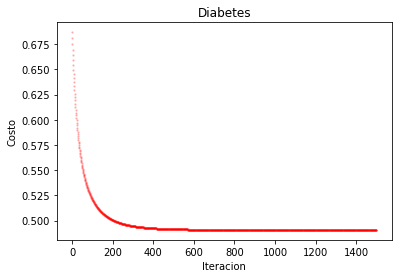

In [15]:
#Experimento 2 Diabetes
_, costos = Gradiente_Descendiente(tr_Diab_x, tr_Diab_y, theta_Diab, its[min[1]], alphas[min[0]])
plt.scatter(np.arange(its[min[1]]),costos,alpha=0.2, c="red", s=2)
plt.xlabel('Iteracion')
plt.ylabel('Costo')
plt.title('Diabetes')

In [19]:
#Experimento 2 Enf Cardiaca

rpta2 = np.zeros([len(alphas),len(its)])

for k in range(3):
  tr_Card, te_Card = split_Tr_Te(full_Card,[k],3)
  tr_Card_x, tr_Card_y, te_Card_x, te_Card_y = gen_Tr_Te(te_Card,te_Card)
  theta_Card = np.zeros(tr_Card_x.shape[1])[np.newaxis]
    
  for a in  range(len(alphas)):
    for itr in range(len(its)):
      tmp_theta, _ = Gradiente_Descendiente(tr_Card_x, tr_Card_y, theta_Card, its[itr], alphas[a])
      rpta2[a,itr] += Calcular_Accuracy(te_Card_x, te_Card_y, tmp_theta)

rpta2 = rpta2/3
min2 = (0,0)
for ta in  range(len(alphas)):
    for itr in range(len(its)):
        if(rpta2[ta,itr] > rpta2[min2[0],min2[1]]):
            min2 = (ta, itr)

C_Card = pd.DataFrame(data = rpta2, index= alphas, columns = its)
print("Mayor accuracy:",alphas[min2[0]],its[min2[1]])
C_Card

Mayor accuracy: 0.05 1000


,500,1000,1500,2000,2500,3000,3500
0.01,84.818482,87.128713,86.798680,87.788779,87.458746,88.118812,88.118812
0.05,87.458746,88.448845,88.118812,87.788779,87.788779,87.788779,87.788779
0.10,88.448845,87.788779,87.788779,87.788779,87.788779,87.788779,87.788779
0.20,87.788779,87.788779,87.788779,87.788779,87.788779,87.788779,87.788779
0.30,87.788779,87.788779,87.788779,87.788779,87.788779,87.788779,87.788779
0.40,87.788779,87.788779,87.788779,87.788779,87.788779,87.788779,87.788779


Text(0.5, 1.0, 'Enfermedad Cardiaca')

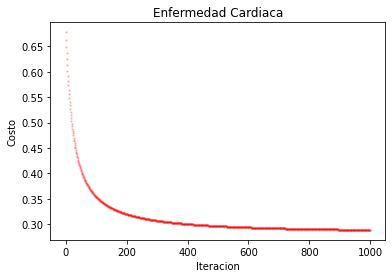

In [20]:
#Experimento 2 Enf Cardiaca
_, costos = Gradiente_Descendiente(tr_Card_x, tr_Card_y, theta_Card, its[min2[1]], alphas[min2[0]])
plt.scatter(np.arange(its[min2[1]]),costos,alpha=0.2, c="red", s=2)
plt.xlabel('Iteracion')
plt.ylabel('Costo')
plt.title('Enfermedad Cardiaca')